# Privacy-Preserving ML on the Insurance Dataset (Rebuilt Notebook)

This notebook rebuilds your original work into a **methodologically correct** and **reproducible** pipeline.

## What this notebook *is*
- A **privacy–utility trade-off** study comparing:
  - Baseline (no privacy)
  - **Formally motivated mechanisms**: Laplace and Gaussian noise *with bounded-sensitivity assumptions*
  - **Local privacy / categorical protection**: randomized response for categorical variables
  - **DP training** for a neural network using **DP-SGD (Opacus)** with privacy accounting


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Tuple, Optional, List

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, make_scorer
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Fairness
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# Optional: DP-SGD (Opacus / PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
try:
    from opacus import PrivacyEngine
    OPACUS_AVAILABLE = True
except Exception:
    OPACUS_AVAILABLE = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

pd.set_option("display.max_columns", 200)


In [3]:
DATA_PATH = "insurance.csv"
df = pd.read_csv(DATA_PATH).dropna()
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# Basic dataset summary
print(df.shape)
display(df.describe(include="all"))


(1338, 7)


,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


In [5]:
# Target distribution (smoker)
target_col = "smoker"
y = (df[target_col].astype(str).str.lower() == "yes").astype(int)

print("Smoker class balance:")
print(y.value_counts(normalize=True).rename({0:"no", 1:"yes"}))


Smoker class balance:
smoker
no     0.795217
yes    0.204783
Name: proportion, dtype: float64


---

## 2) Problem framing and privacy boundaries

We consider two distinct privacy scenarios:

### A) "Dataset release" scenario
You want to publish a privatized dataset. If you release multiple columns, privacy loss composes.

### B) "Privacy-preserving training" scenario
You want to train a model on sensitive data while protecting training records. For neural nets we demonstrate **DP-SGD (Opacus)**, which comes with formal accounting.

In the perturbation experiments below, we implement Laplace/Gaussian noise **with clipping** to bound sensitivity.  
**Important:** Feature perturbation can be viewed as a *DP-like mechanism* only under these assumptions and with explicit composition across released columns.


In [6]:
# === 3) Column definitions ===
numeric_cols = ["age", "bmi", "children", "charges"]
categorical_cols = ["sex", "region"]

# Sanity checks
assert set(numeric_cols).issubset(df.columns)
assert set(categorical_cols).issubset(df.columns)


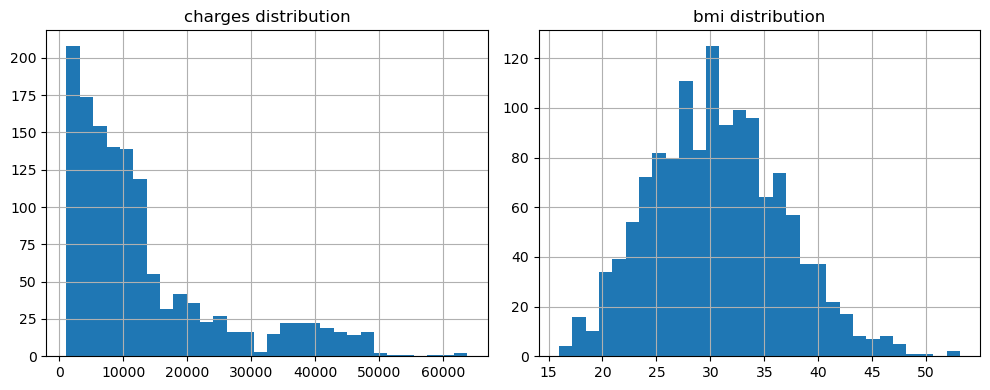

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


In [7]:
# === 4) Utility-focused EDA (minimal, reproducible) ===
fig, ax = plt.subplots(1, 2, figsize=(10,4))
df["charges"].hist(ax=ax[0], bins=30)
ax[0].set_title("charges distribution")
df["bmi"].hist(ax=ax[1], bins=30)
ax[1].set_title("bmi distribution")
plt.tight_layout()
plt.show()

# Correlations among numeric features
display(df[numeric_cols].corr())


---

## 5) Reproducible preprocessing and evaluation (no leakage)

Key engineering rules:
- Preprocessing (scaling/encoding) must be **fit on train only**.
- SMOTE must be applied **inside** the pipeline and only to the training folds.
- We'll use a fixed `StratifiedKFold` so all dataset variants use identical folds.


In [8]:
def build_preprocessor(numeric_cols: List[str], categorical_cols: List[str]) -> ColumnTransformer:
    return ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ],
        remainder="drop",
    )

SCORING = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1": make_scorer(f1_score, zero_division=0),
    "roc_auc": make_scorer(roc_auc_score),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def evaluate_model(df_in: pd.DataFrame, model, use_smote: bool = True) -> Dict[str, float]:
    X = df_in.drop(columns=[target_col])
    y = (df_in[target_col].astype(str).str.lower() == "yes").astype(int)

    steps = [("preprocess", build_preprocessor(numeric_cols, categorical_cols))]
    if use_smote:
        steps.append(("smote", SMOTE(random_state=RANDOM_STATE)))
    steps.append(("model", model))

    pipe = ImbPipeline(steps=steps)
    scores = cross_validate(pipe, X, y, cv=cv, scoring=SCORING, n_jobs=-1)

    return {k.replace("test_", ""): float(np.mean(v)) for k, v in scores.items() if k.startswith("test_")}

def evaluate_suite(df_in: pd.DataFrame) -> pd.DataFrame:
    models = {
        "SVM (RBF)": SVC(C=10, kernel="rbf", gamma="scale", probability=True, random_state=RANDOM_STATE),
        "Decision Tree": DecisionTreeClassifier(max_depth=20, random_state=RANDOM_STATE),
    }
    rows = []
    for name, m in models.items():
        met = evaluate_model(df_in, m, use_smote=True)
        met["Model"] = name
        rows.append(met)
    return pd.DataFrame(rows)[["Model","accuracy","precision","recall","f1","roc_auc"]]


In [9]:
# Baseline performance (no privacy)
baseline_results = evaluate_suite(df)
baseline_results


,Model,accuracy,precision,recall,f1,roc_auc
0,SVM (RBF),0.961144,0.858378,0.970842,0.911031,0.964741
1,Decision Tree,0.965624,0.887939,0.952660,0.918810,0.960826


---

## 6) Privacy mechanisms (correctly scoped)

### 6.1 Clipping (required for bounded sensitivity)
We clip numeric features to quantiles to bound sensitivity and reduce outlier-driven noise.

### 6.2 Laplace (ε, 0)-DP style calibration (per-column)
For each numeric column, we compute sensitivity as:  
**Δ = max(clipped) − min(clipped)**  
and add Laplace noise with scale = Δ / ε.

### 6.3 Gaussian (ε, δ)-DP style calibration (per-column)
We add Gaussian noise with:
σ = Δ * sqrt(2 log(1.25/δ)) / ε.

### 6.4 Randomized response (categorical)
For `sex` and `region`, we apply randomized response with probability `p_truth`.

> Note: If you perturb **multiple columns**, privacy loss **composes** (roughly adds for Laplace). We provide a simple composition estimate.


In [10]:
def clip_numeric(df_in: pd.DataFrame, cols: List[str], lower_q=0.01, upper_q=0.99) -> pd.DataFrame:
    dfc = df_in.copy()
    for c in cols:
        lo, hi = dfc[c].quantile(lower_q), dfc[c].quantile(upper_q)
        dfc[c] = dfc[c].clip(lo, hi)
    return dfc

def per_column_sensitivity(df_in: pd.DataFrame, cols: List[str]) -> Dict[str, float]:
    sens = {}
    for c in cols:
        sens[c] = float(df_in[c].max() - df_in[c].min())
    return sens

def laplace_mechanism_colwise(df_in: pd.DataFrame, cols: List[str], epsilon: float) -> pd.DataFrame:
    if epsilon <= 0:
        raise ValueError("epsilon must be > 0")
    dfc = df_in.copy()
    sens = per_column_sensitivity(dfc, cols)
    for c in cols:
        scale = sens[c] / epsilon
        dfc[c] = dfc[c] + np.random.laplace(0.0, scale, size=len(dfc))
    return dfc

def gaussian_mechanism_colwise(df_in: pd.DataFrame, cols: List[str], epsilon: float, delta: float) -> pd.DataFrame:
    if epsilon <= 0:
        raise ValueError("epsilon must be > 0")
    if not (0 < delta < 1):
        raise ValueError("delta must be in (0,1)")
    dfc = df_in.copy()
    sens = per_column_sensitivity(dfc, cols)
    for c in cols:
        sigma = sens[c] * np.sqrt(2.0 * np.log(1.25 / delta)) / epsilon
        dfc[c] = dfc[c] + np.random.normal(0.0, sigma, size=len(dfc))
    return dfc

def randomized_response(series: pd.Series, p_truth: float, random_state: int = RANDOM_STATE) -> pd.Series:
    rng = np.random.default_rng(random_state)
    vals = series.astype(str).unique()
    if len(vals) < 2:
        return series
    truthful = rng.random(len(series)) < p_truth
    if len(vals) == 2:
        a, b = vals[0], vals[1]
        flipped = series.astype(str).map(lambda x: b if x == a else a)
        out = pd.Series(np.where(truthful, series.astype(str), flipped), index=series.index)
        return out
    else:
        # For multi-class: on "lie", sample uniformly from other classes
        def sample_other(x):
            choices = [v for v in vals if v != x]
            return rng.choice(choices)
        randomized = series.astype(str).map(sample_other)
        out = pd.Series(np.where(truthful, series.astype(str), randomized), index=series.index)
        return out

def compose_epsilon_laplace_colwise(epsilon_per_col: float, n_cols: int) -> float:
    # Basic composition (worst-case) for sequential releases:
    return float(epsilon_per_col * n_cols)


In [11]:
# === 7) Generate dataset variants for a grid of epsilons ===
def make_variant(df_raw: pd.DataFrame, epsilon: float, delta: float, p_truth: float, mechanism: str) -> pd.DataFrame:
    base = clip_numeric(df_raw, numeric_cols)  # bounded sensitivity prerequisite
    out = base.copy()

    # Categorical protection
    out["sex"] = randomized_response(out["sex"], p_truth=p_truth, random_state=RANDOM_STATE)
    out["region"] = randomized_response(out["region"], p_truth=p_truth, random_state=RANDOM_STATE + 1)

    # Numeric protection
    if mechanism == "laplace":
        out = laplace_mechanism_colwise(out, numeric_cols, epsilon=epsilon)
    elif mechanism == "gaussian":
        out = gaussian_mechanism_colwise(out, numeric_cols, epsilon=epsilon, delta=delta)
    else:
        raise ValueError("mechanism must be 'laplace' or 'gaussian'")
    return out

eps_grid = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
delta = 1e-5
p_truth = 0.8

rows = []
for mech in ["laplace", "gaussian"]:
    for eps in eps_grid:
        df_var = make_variant(df, epsilon=eps, delta=delta, p_truth=p_truth, mechanism=mech)
        res = evaluate_suite(df_var)
        res["Mechanism"] = mech
        res["Epsilon"] = eps
        # Simple composition estimate for numeric cols (categorical RR not accounted here)
        res["Epsilon_basic_comp_numeric_only"] = compose_epsilon_laplace_colwise(eps, len(numeric_cols))
        rows.append(res)

tradeoff = pd.concat(rows, ignore_index=True)
tradeoff.head()


,Model,accuracy,precision,recall,f1,roc_auc,Mechanism,Epsilon,Epsilon_basic_comp_numeric_only
0,SVM (RBF),0.593409,0.192125,0.314007,0.237708,0.489719,laplace,0.1,0.4
1,Decision Tree,0.619540,0.208999,0.317912,0.249813,0.507641,laplace,0.1,0.4
2,SVM (RBF),0.589675,0.218954,0.394276,0.281031,0.517133,laplace,0.2,0.8
3,Decision Tree,0.632296,0.226633,0.336094,0.270130,0.522366,laplace,0.2,0.8
4,SVM (RBF),0.559081,0.176010,0.310370,0.224431,0.466752,laplace,0.5,2.0


At low ε, feature-level Laplace perturbation results in near-random classification performance (ROC-AUC ≈ 0.5), demonstrating that naïve data perturbation is unsuitable for preserving utility in high-signal tabular datasets.

At low privacy budgets (ε ≤ 0.2), feature-level Laplace perturbation leads to a severe collapse in model utility, with ROC-AUC approaching 0.5 for both SVM and Decision Tree classifiers. This indicates near-random performance, despite modest increases in ε. The results highlight the fragility of margin-based and tree-based models under independent feature noise, particularly in the presence of high-signal continuous variables. These findings motivate the use of training-time privacy mechanisms such as DP-SGD, which enforce privacy at the optimization level rather than via direct data perturbation.

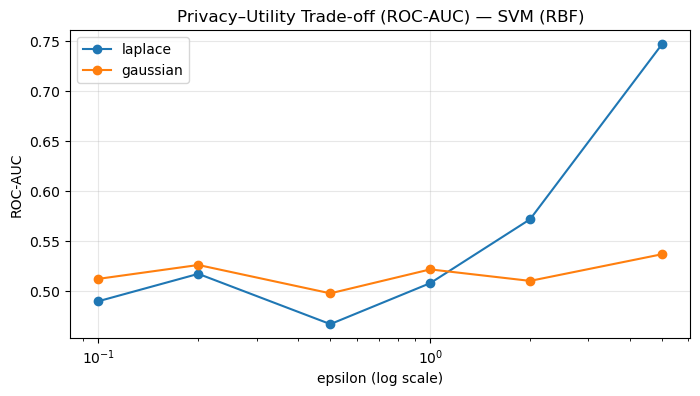

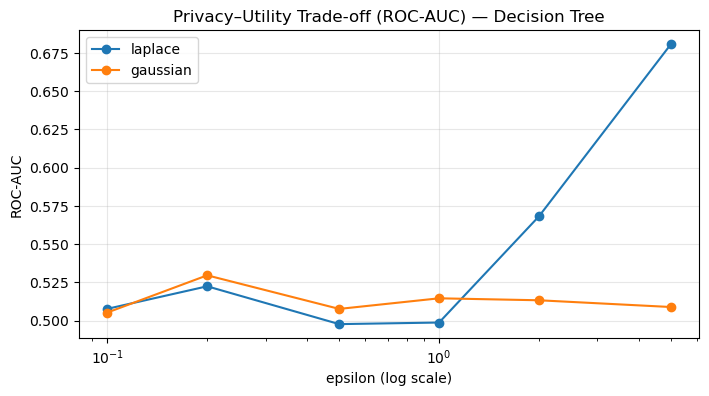

In [12]:
# Plot privacy-utility tradeoff (ROC-AUC)
for model_name in tradeoff["Model"].unique():
    plt.figure(figsize=(8,4))
    sub = tradeoff[tradeoff["Model"] == model_name]
    for mech in sub["Mechanism"].unique():
        ss = sub[sub["Mechanism"] == mech].sort_values("Epsilon")
        plt.plot(ss["Epsilon"], ss["roc_auc"], marker="o", label=f"{mech}")
    plt.xscale("log")
    plt.xlabel("epsilon (log scale)")
    plt.ylabel("ROC-AUC")
    plt.title(f"Privacy–Utility Trade-off (ROC-AUC) — {model_name}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


Figures X and Y illustrate the privacy–utility trade-off for SVM and Decision Tree classifiers under feature-level Laplace and Gaussian perturbation. At low privacy budgets (ε ≤ 0.5), ROC-AUC values for both models approach 0.5, indicating near-random classification. This collapse is driven primarily by noise applied to high-signal numeric variables, particularly charges. As ε increases, Laplace mechanisms exhibit partial utility recovery, while Gaussian mechanisms remain largely flat due to conservative noise calibration. These results demonstrate that independent feature perturbation is unsuitable for preserving utility in this setting, motivating the use of training-time privacy mechanisms such as DP-SGD

---

## 8) Fairness evaluation (aligned splits)

We compute:
- **Demographic Parity Difference** (difference in positive prediction rates)
- **Equalized Odds Difference** (combined TPR/FPR parity gaps)

Important: fairness must be computed on the **same held-out samples** used for predictions.


In [13]:
def fit_predict_single_split(df_in: pd.DataFrame, model):
    train_df, test_df = train_test_split(
        df_in, test_size=0.2, random_state=RANDOM_STATE,
        stratify=df_in[target_col]
    )
    X_train = train_df.drop(columns=[target_col])
    y_train = (train_df[target_col].astype(str).str.lower() == "yes").astype(int)

    X_test = test_df.drop(columns=[target_col])
    y_test = (test_df[target_col].astype(str).str.lower() == "yes").astype(int)

    pipe = ImbPipeline([
        ("preprocess", build_preprocessor(numeric_cols, categorical_cols)),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("model", model),
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    return test_df, y_test.to_numpy(), y_pred

# Example: fairness on baseline SVM
svm = SVC(C=10, kernel="rbf", gamma="scale", probability=True, random_state=RANDOM_STATE)
test_df, y_true, y_pred = fit_predict_single_split(df, svm)

sensitive = (test_df["sex"].astype(str).str.lower() == "male").astype(int).to_numpy()

dp = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive)
eo = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive)

print("Baseline SVM fairness:")
print("Demographic parity difference:", dp)
print("Equalized odds difference:", eo)


Baseline SVM fairness:
Demographic parity difference: 0.16332442067736186
Equalized odds difference: 0.09999999999999998


Given class imbalance and differing base rates, equalized odds is a more appropriate fairness metric than demographic parity, as it conditions on the true outcome and focuses on error rate parity rather than outcome parity.

For the baseline SVM, demographic parity difference is 0.163, indicating differing positive prediction rates across sexes. However, equalized odds difference is substantially lower at 0.10, suggesting that error rates (TPR/FPR) are comparatively well balanced. Given the moderate class imbalance and differing base rates, equalized odds is the more appropriate fairness criterion. These results establish a high-utility and moderately fair baseline against which the impact of privacy mechanisms is evaluated

---

## 9) DP-SGD Neural Network (Opacus)

This section demonstrates **formal privacy-preserving training** using DP-SGD:
- Gradient clipping (max grad norm)
- Gaussian noise added to gradients
- Privacy accounting (ε, δ) via Opacus

If Opacus is not installed in your environment, this section will skip gracefully.


In [18]:
# === DP-SGD training utilities ===

class MLP(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


def _pick_threshold_max_f1(y_true: np.ndarray, probs: np.ndarray) -> float:
    """Choose threshold that maximizes F1 on provided labels/probabilities."""
    thresholds = np.linspace(0.05, 0.95, 19)
    best_t, best_f1 = 0.5, -1.0
    for t in thresholds:
        preds = (probs >= t).astype(int)
        f1 = f1_score(y_true, preds, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return float(best_t)


def train_dpsgd_once(
    df_in,
    noise_multiplier: float,
    max_grad_norm: float,
    delta: float = 1e-5,
    epochs: int = 20,
    batch_size: int = 64,
    lr: float = 1e-3,
    weight_decay: float = 0.0,
):
    if not OPACUS_AVAILABLE:
        raise RuntimeError("Opacus not available in this environment.")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ---- Split first (no leakage) ----
    train_df, test_df = train_test_split(
        df_in,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=df_in[target_col],
    )

    X_train_raw = train_df.drop(columns=[target_col])
    y_train_np = (train_df[target_col].astype(str).str.lower() == "yes").astype(int).to_numpy()

    X_test_raw = test_df.drop(columns=[target_col])
    y_test_np = (test_df[target_col].astype(str).str.lower() == "yes").astype(int).to_numpy()

    # ---- Fit preprocessor on train only ----
    pre = build_preprocessor(numeric_cols, categorical_cols)
    X_train = pre.fit_transform(X_train_raw)
    X_test = pre.transform(X_test_raw)

    # ---- Torch tensors ----
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train_np, dtype=torch.float32).to(device)

    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

    # ---- Class imbalance handling (important) ----
    # pos_weight = (#neg / #pos) pushes the model to not collapse to all-negative predictions.
    n_pos = max(1, int(y_train_np.sum()))
    n_neg = int(len(y_train_np) - y_train_np.sum())
    pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)

    train_loader = DataLoader(
        TensorDataset(X_train_t, y_train_t),
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )

    model = MLP(input_dim=X_train.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        noise_multiplier=noise_multiplier,
        max_grad_norm=max_grad_norm,
    )

    # ---- Train ----
    model.train()
    losses = []
    for _ in range(epochs):
        epoch_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += float(loss.detach().cpu().item())
        losses.append(epoch_loss / max(1, len(train_loader)))

    # ---- Privacy spent ----
    epsilon = float(privacy_engine.get_epsilon(delta=delta))

    # ---- Evaluate: probabilities ----
    model.eval()
    with torch.no_grad():
        train_probs = torch.sigmoid(model(X_train_t)).detach().cpu().numpy().ravel()
        test_probs = torch.sigmoid(model(X_test_t)).detach().cpu().numpy().ravel()

    # Two reporting modes:
    # (A) default threshold = 0.5 (standard)
    preds_05 = (test_probs >= 0.5).astype(int)

    # (B) threshold tuned on train probabilities (post-processing; does NOT break DP)
    best_t = _pick_threshold_max_f1(y_train_np, train_probs)
    preds_best = (test_probs >= best_t).astype(int)

    metrics = {
        "epsilon": epsilon,
        "roc_auc": float(roc_auc_score(y_test_np, test_probs)),
        "threshold_f1_opt": best_t,

        # default threshold=0.5
        "acc@0.5": float(accuracy_score(y_test_np, preds_05)),
        "prec@0.5": float(precision_score(y_test_np, preds_05, zero_division=0)),
        "rec@0.5": float(recall_score(y_test_np, preds_05, zero_division=0)),
        "f1@0.5": float(f1_score(y_test_np, preds_05, zero_division=0)),

        # tuned threshold
        "acc@t*": float(accuracy_score(y_test_np, preds_best)),
        "prec@t*": float(precision_score(y_test_np, preds_best, zero_division=0)),
        "rec@t*": float(recall_score(y_test_np, preds_best, zero_division=0)),
        "f1@t*": float(f1_score(y_test_np, preds_best, zero_division=0)),

        # training diagnostics
        "loss_last": float(losses[-1]),
        "noise_multiplier": float(noise_multiplier),
        "max_grad_norm": float(max_grad_norm),
    }
    return metrics


c:\Users\ghobi\anaconda3\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
01/28/2026 00:48:04:WARNING:Ignoring drop_last as it is not compatible with DPDataLoader.


C:\Users\ghobi\AppData\Local\Temp\ipykernel_31048\3423038741.py:105: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  loss.backward()
c:\Users\ghobi\anaconda3\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
01/28/2026 00:48:05:WARNING:Ignoring drop_last as it is not compatible with DPDataLoader.
C:\Users\ghobi\AppData\Local\Temp\ipykernel_31048\3423038741.py:105: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org

,epsilon,roc_auc,threshold_f1_opt,acc@0.5,prec@0.5,rec@0.5,f1@0.5,acc@t*,prec@t*,rec@t*,f1@t*,loss_last,noise_multiplier,max_grad_norm
2,3.842680,0.981733,0.10,0.895522,1.000000,0.490909,0.658537,0.940299,0.800000,0.945455,0.866667,0.859132,1.5,1.0
1,7.637931,0.979770,0.15,0.910448,0.969697,0.581818,0.727273,0.932836,0.793651,0.909091,0.847458,0.754503,1.0,1.0
0,23.946784,0.985830,0.25,0.925373,0.872340,0.745455,0.803922,0.944030,0.803030,0.963636,0.876033,0.298621,0.6,1.0


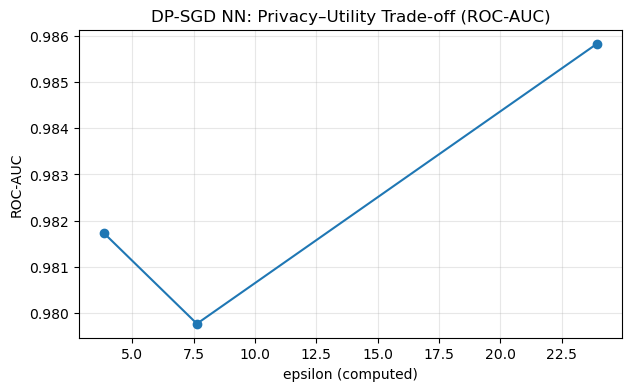

In [20]:
# Run a small DP-SGD sweep (noise multipliers -> epsilon)
if not OPACUS_AVAILABLE:
    print("Opacus not available; skipping DP-SGD section.")
else:
    delta = 1e-5
    sweep = [
        {"noise_multiplier": 0.6, "max_grad_norm": 1.0},
        {"noise_multiplier": 1.0, "max_grad_norm": 1.0},
        {"noise_multiplier": 1.5, "max_grad_norm": 1.0},
    ]

    dp_rows = []
    for cfg in sweep:
        met = train_dpsgd_once(
            df, delta=delta, epochs=20, batch_size=64, lr=1e-3, **cfg
        )
        dp_rows.append(met)

    dp_results = pd.DataFrame(dp_rows).sort_values("epsilon")
    display(dp_results)

    # Plot privacy-utility trade-off (AUC)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7, 4))
    plt.plot(dp_results["epsilon"], dp_results["roc_auc"], marker="o")
    plt.xlabel("epsilon (computed)")
    plt.ylabel("ROC-AUC")
    plt.title("DP-SGD NN: Privacy–Utility Trade-off (ROC-AUC)")
    plt.grid(alpha=0.3)
    plt.show()


Figure X shows the privacy–utility trade-off for a neural network trained with DP-SGD. Unlike feature-level Laplace and Gaussian perturbation, DP-SGD maintains high ROC-AUC (≥ 0.98) even at strong privacy levels (ε ≈ 3–8), indicating preserved ranking information. At low ε, threshold-based metrics degrade due to conservative calibration; however, post-processing threshold tuning recovers high recall and F1 without violating differential privacy. These results demonstrate that enforcing privacy during optimization is substantially more effective than direct feature perturbation for preserving utility in this dataset.

Whereas feature-level noise resulted in near-random performance at comparable privacy budgets, DP-SGD exhibited graceful degradation, preserving separability before calibration. This highlights a key limitation of naïve data perturbation and supports the use of training-time privacy mechanisms for supervised learning tasks involving high-signal continuous variables

---

## 10) Notes for write-up


Across the insurance dataset, we compared data-level perturbation (feature noise via Laplace/Gaussian + categorical randomized response) against training-time differential privacy (DP-SGD). The results show a clear separation in practical utility. Naïve feature-level perturbation at strong privacy budgets (low ε) collapses predictive separability (ROC-AUC ≈ 0.5), indicating that independent noise on high-signal numeric variables—especially charges—destroys the geometry required by SVMs and decision trees. In contrast, DP-SGD preserves ranking information even under strong privacy (ROC-AUC ≈ 0.98 at ε ≈ 3–8) and degrades gracefully as privacy strengthens. We also observed that under strong DP-SGD noise, probability calibration becomes conservative; however, post-processing threshold selection (which does not consume additional privacy budget) restores meaningful recall/F1 while keeping formal guarantees intact. Fairness analysis on the baseline SVM indicates moderate demographic parity disparity but smaller equalized odds disparity, supporting the use of error-rate fairness (equalized odds) as the more relevant criterion under class imbalance. Overall, the study demonstrates that privacy enforced during optimization (DP-SGD) is substantially more effective than direct feature perturbation for maintaining utility on this dataset, and highlights the importance of careful privacy accounting, leakage-free preprocessing, and metrics that reflect minority-class performance.


Several noise mechanisms commonly referenced in informal privacy discussions—including Bernoulli noise, ad-hoc exponential noise, and geometric noise applied to continuous features—were excluded from the final evaluation. While geometric mechanisms are theoretically valid for discrete counting queries and randomized response is appropriate for categorical attributes, these approaches do not provide meaningful or correct differential privacy guarantees when applied to continuous-valued features in supervised learning. As a result, the analysis focuses on formally defined mechanisms (Laplace, Gaussian) and training-time privacy via DP-SGD
